In [1]:
# ! pip install pandas numpy scikit-learn matplotlib tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [5]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPrices.csv')

In [6]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [7]:
data.head()

,Price
Date,
2023-04-03,84.930000
2023-04-04,84.940002
2023-04-05,84.989998
2023-04-06,85.120003
2023-04-10,84.180000


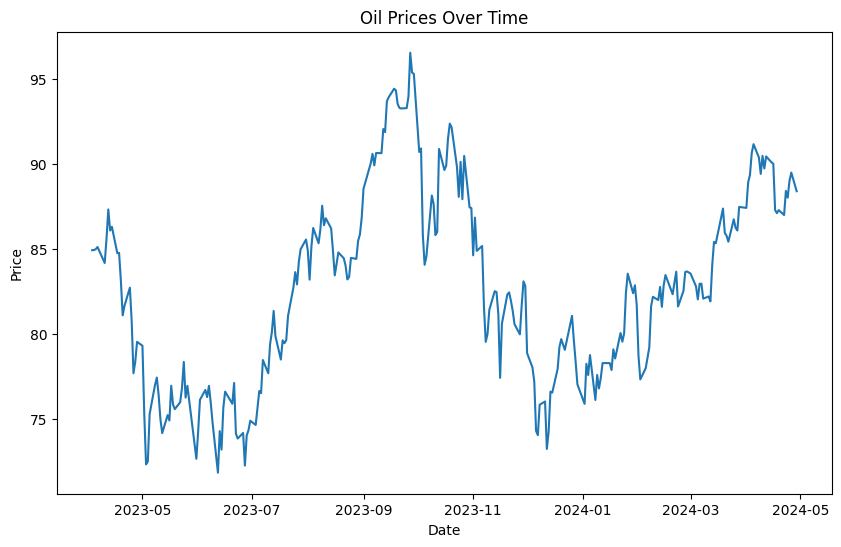

In [8]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [9]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [10]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [11]:
seq_length = 60
X, y = create_sequences(data['Price'].values, seq_length)

In [12]:
X[0], y[0]

(array([0.52974506, 0.53014984, 0.53217313, 0.53743435, 0.49939298,
        0.55726429, 0.62687176, 0.57668944, 0.58559277, 0.52286533,
        0.5232698 , 0.45649548, 0.37474705, 0.39741014, 0.44071243,
        0.36139206, 0.23674644, 0.26426567, 0.31161483, 0.30230673,
        0.14083377, 0.01983025, 0.02670998, 0.14002452, 0.20922721,
        0.22662908, 0.18494561, 0.12707431, 0.09429386, 0.13719167,
        0.12424146, 0.20720362, 0.1626873 , 0.15135591, 0.16794822,
        0.20234717, 0.26386089, 0.17887514, 0.20679884, 0.06879822,
        0.03318523, 0.09874552, 0.17361391, 0.19708626, 0.18008917,
        0.20679884, 0.16673418, 0.11938502, 0.        , 0.0991503 ,
        0.05503846, 0.15499801, 0.19303938, 0.16430611, 0.21367887,
        0.09307982, 0.08134365, 0.09469864, 0.0169974 , 0.08862816]),
 0.10117358643196983)

In [13]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = y[:split], y[split:]

In [14]:
# Reshape X for LSTM [samples, time steps, features]
# [1,2,3,4,5,6,7] , [2,3,4,5,6,7,8] , 
# [[1] , [2],[3],[4]]
# []

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [15]:
# 3. Build the LSTM model
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(50, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1))

In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model1.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# 4. Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history1 = model1.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 6s 286ms/step - loss: 0.2862 - val_loss: 0.1366 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 59ms/step - loss: 0.0451 - val_loss: 0.0085 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 67ms/step - loss: 0.0324 - val_loss: 0.0083 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0205 - val_loss: 0.0200 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 61ms/step - loss: 0.0226 - val_loss: 0.0100 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 75ms/step - loss: 0.0193 - val_loss: 0.0056 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 69ms/step - loss: 0.0190 - val_loss: 0.0065 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 70ms/step - loss: 0.0177 - val_loss: 0.0086 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 0s 68ms/step - loss: 0.0175 - val_loss: 0.0085 - lr: 0.0010


In [ ]:
# 11 months - train- x,y - x=[1,2,3,4,5,6,7] y=[8]

# 12th month - test - x , y

In [ ]:
# (8-4)**2 = 160
# mean square error = 1000/10 = 100
# root mean square error = 10


#mean absolute error
# (8-4) + (8-9) ...
# 4 + 1 + ....
#mean absolute error = 1000/10 = 100

#mean absolute error
# (8-4)/8 + (5-9)/5 ...
# 4/8 + 4/5 + ....
#0.5 + 0.2 ...
#mean absolute error = 4/10 = 0.4 = 40%

In [19]:
# 5. Evaluate the model
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)

2/2 [==============================] - 0s 11ms/step


In [20]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# y_pred = model1.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
print('Model 01:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 01:
Train Mean Absolute Error: 2.5475669134230836
Train Root Mean Squared Error: 3.197268429601836
Test Mean Absolute Error: 1.542487920716752
Test Root Mean Squared Error: 1.845188660647216


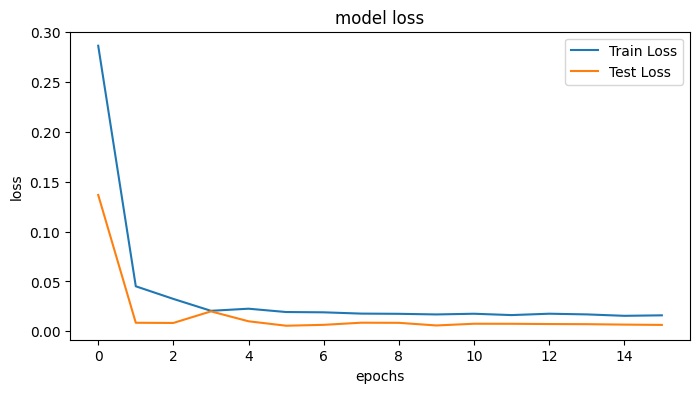

In [23]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs1/lstm model 01 model loss.png')
plt.show()

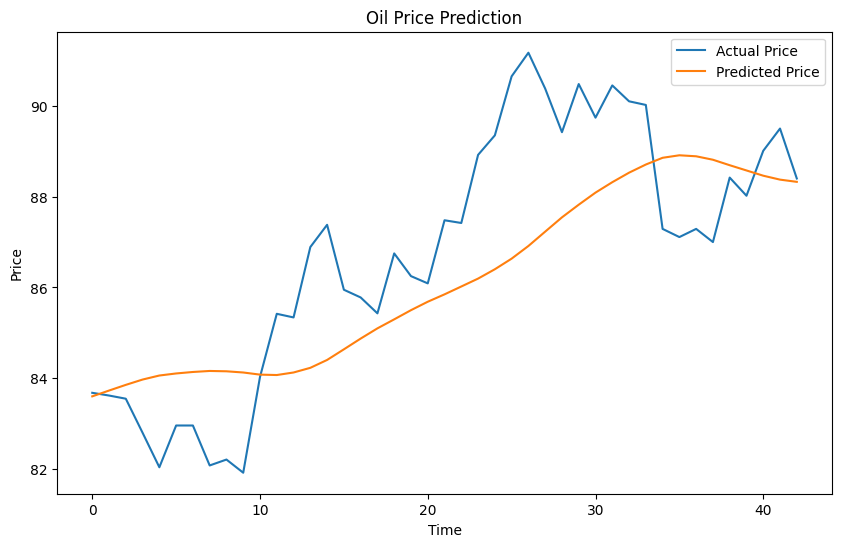

In [24]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs1/lstm model 01 Oil Price Prediction.png')
plt.show()

In [25]:
model1.save('models/LSTM_01.h5') 

# returns a compiled model
# identical to the previous one
# model1 = load_model('my_model.h5')

C:\Users\wgras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### model 2

In [26]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(units=60, return_sequences=True, input_shape=(seq_length, 1)))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60, return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60, return_sequences=False))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 60)            14880     
                                                                 
 dropout_2 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_3 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [28]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history2 = model2.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 11s 684ms/step - loss: 6928.1294 - val_loss: 7334.3442 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 221ms/step - loss: 6604.6577 - val_loss: 6793.9360 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 249ms/step - loss: 6158.2148 - val_loss: 6508.9565 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 235ms/step - loss: 5905.2852 - val_loss: 6276.6367 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 1s 224ms/step - loss: 5706.5898 - val_loss: 6105.9653 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 1s 172ms/step - loss: 5558.4307 - val_loss: 5980.1982 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 1s 122ms/step - loss: 5448.9170 - val_loss: 5876.7217 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 1s 119ms/step - loss: 5358.3506 - val_loss: 5785.4097 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 1s 1

In [30]:
# Evaluate the model
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


2/2 [==============================] - 0s 28ms/step


In [25]:
print('Model 02:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 02:
Train Mean Absolute Error: 1029.0107454355484
Train Root Mean Squared Error: 1037.4004382377768
Test Mean Absolute Error: 1113.726860999169
Test Root Mean Squared Error: 1115.789324363714


#### by observing results with model 01 and model 02, model 01 seems to perform better

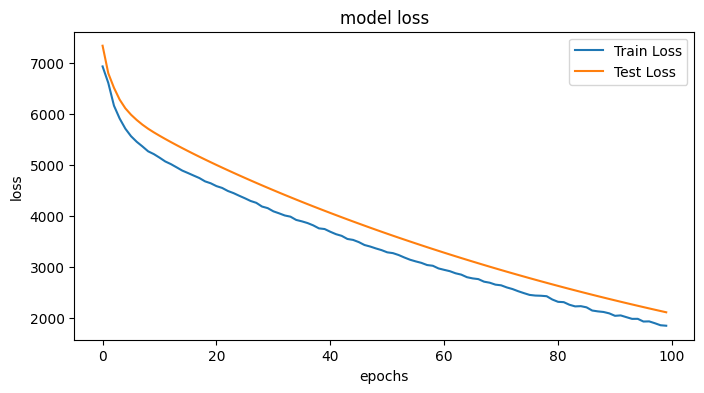

In [31]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs1/lstm model 02 model loss.png')
plt.show()

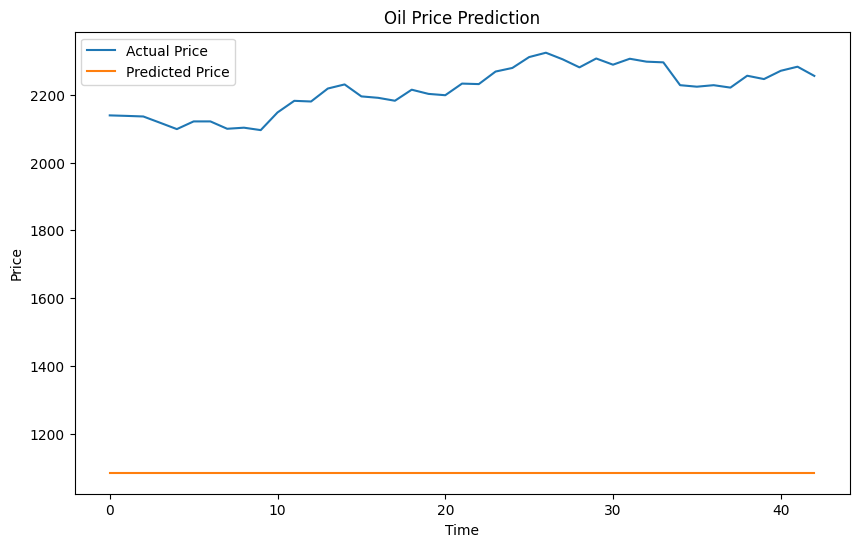

In [32]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs1/lstm model 02 Oil Price Prediction.png')
plt.show()

In [33]:
model2.save('models/LSTM_02.h5') 

# returns a compiled model
# identical to the previous one
# model2 = load_model('my_model.h5')

C:\Users\wgras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### model 3

In [34]:
# Build the LSTM model
model3 = Sequential()
model3.add(LSTM(units=60, return_sequences=True, input_shape=(seq_length, 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=40, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=30, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=20, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))

In [35]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 60, 60)            14880     
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            22200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 40)            14560     
                                                                 
 dropout_7 (Dropout)         (None, 60, 40)            0         
                                                                 
 lstm_8 (LSTM)               (None, 60, 30)           

In [36]:
model3.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history3 = model3.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 12s 498ms/step - loss: 4557583.0000 - val_loss: 4910216.0000 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 1s 107ms/step - loss: 4552966.0000 - val_loss: 4904504.5000 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 1s 104ms/step - loss: 4548169.5000 - val_loss: 4900495.0000 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 1s 106ms/step - loss: 4544680.0000 - val_loss: 4897487.5000 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 1s 103ms/step - loss: 4541451.0000 - val_loss: 4894845.5000 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 1s 107ms/step - loss: 4539469.5000 - val_loss: 4892378.5000 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 1s 103ms/step - loss: 4536716.0000 - val_loss: 4890018.0000 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 1s 113ms/step - loss: 4535364.0000 - val_loss: 4887674.0000 - lr: 0.0010
Epoch 9

In [38]:
# Evaluate the model
train_predict = model3.predict(X_train)
test_predict = model3.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


2/2 [==============================] - 0s 22ms/step


In [39]:
print('Model 03:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 03:
Train Mean Absolute Error: 52170.82591341784
Train Root Mean Squared Error: 52272.177179576225
Test Mean Absolute Error: 54264.16169776765
Test Root Mean Squared Error: 54290.02571723346


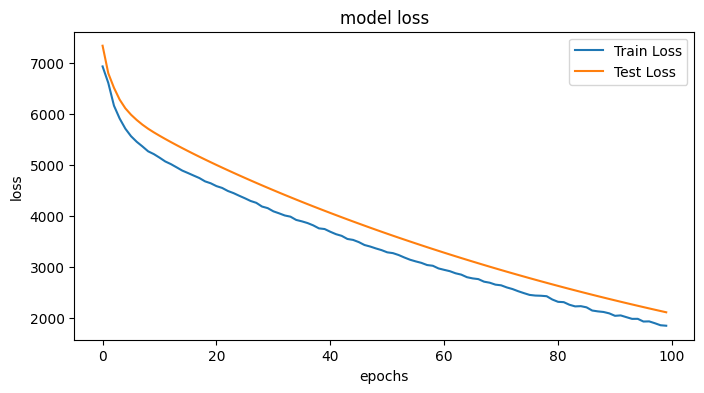

In [40]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs1/lstm model 03 model loss.png')
plt.show()

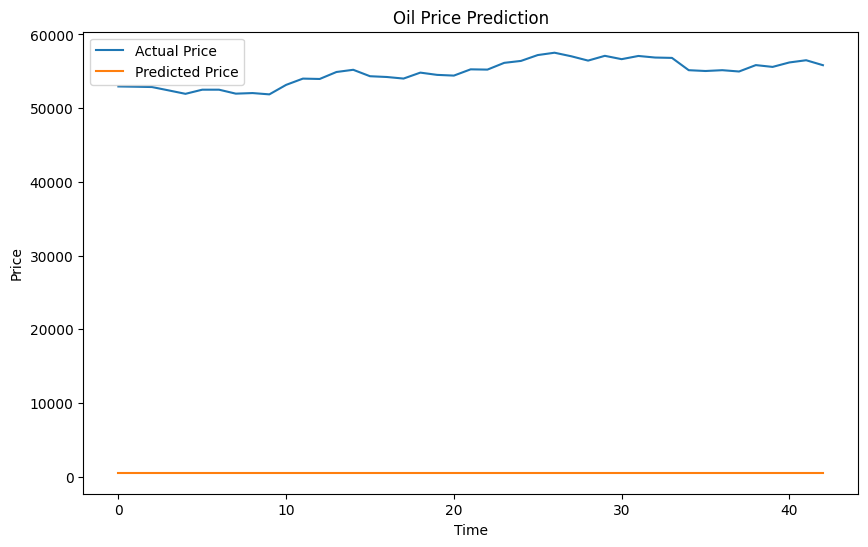

In [41]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs1/lstm model 03 Oil Price Prediction.png')
plt.show()

In [42]:
model3.save('models/LSTM_03.h5') 


C:\Users\wgras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
